In [1]:
!pip install transformers[tf-cpu] tensorflow -U
!pip install nltk

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of onnxconverter-common to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninst

In [2]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import os
import subprocess
import nltk
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


os.environ["WANDB_DISABLED"] = "true"

2024-06-07 17:16:59.244937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 17:16:59.245000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 17:16:59.246423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set NLTK data path to /kaggle/working/nltk_data
nltk.data.path.append("/kaggle/working/nltk_data")

# Download and unzip wordnet
try:
    nltk.data.find('corpora/wordnet.zip')
except LookupError:
    nltk.download('wordnet', download_dir='/kaggle/working/nltk_data')
    command = "unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/nltk_data')

from nltk.corpus import wordnet
import random

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/verb.exc 

In [4]:
# Load and preprocess the data
data = pd.read_csv('/kaggle/input/expense-data-1/expense_data_1.csv')
data = data.dropna(subset=['Category', 'Note'])  # Drop rows with missing values in 'Category' or 'Note'
for category in data['Category'].unique():
    print(category)
data.head()

Food
Other
Transportation
Apparel
Household
Social Life
Education
Allowance
Beauty
Gift


,Date,Account,Category,Subcategory,Note,INR,Income/Expense,Note.1,Amount,Currency,Account.1
0,3/2/2022 10:11,CUB - online payment,Food,NaN,Brownie,50.0,Expense,NaN,50.0,INR,50.0
1,3/2/2022 10:11,CUB - online payment,Other,NaN,To lended people,300.0,Expense,NaN,300.0,INR,300.0
2,3/1/2022 19:50,CUB - online payment,Food,NaN,Dinner,78.0,Expense,NaN,78.0,INR,78.0
3,3/1/2022 18:56,CUB - online payment,Transportation,NaN,Metro,30.0,Expense,NaN,30.0,INR,30.0
4,3/1/2022 18:22,CUB - online payment,Food,NaN,Snacks,67.0,Expense,NaN,67.0,INR,67.0


In [5]:
additional_data = pd.read_csv('/kaggle/input/expense-data-2/expenses_2.csv')
additional_data.head()


,Note,Category
0,Groceries for the week,Food
1,Dinner with friends,Social Life
2,Gasoline refill,Transportation
3,New shoes,Apparel
4,Monthly rent,Household


In [6]:
len(additional_data)

14908

In [7]:
merged_data = pd.concat([data, additional_data[['Note', 'Category']]], ignore_index=True)
print(f"Merged data shape: {merged_data.shape}")
merged_data.to_csv('merged_expense_data.csv', index=False)
for category in merged_data['Category'].unique():
    print(category)
merged_data.head()

Merged data shape: (15177, 11)
Food
Other
Transportation
Apparel
Household
Social Life
Education
Allowance
Beauty
Gift
Pet
Entertainment
Health


,Date,Account,Category,Subcategory,Note,INR,Income/Expense,Note.1,Amount,Currency,Account.1
0,3/2/2022 10:11,CUB - online payment,Food,NaN,Brownie,50.0,Expense,NaN,50.0,INR,50.0
1,3/2/2022 10:11,CUB - online payment,Other,NaN,To lended people,300.0,Expense,NaN,300.0,INR,300.0
2,3/1/2022 19:50,CUB - online payment,Food,NaN,Dinner,78.0,Expense,NaN,78.0,INR,78.0
3,3/1/2022 18:56,CUB - online payment,Transportation,NaN,Metro,30.0,Expense,NaN,30.0,INR,30.0
4,3/1/2022 18:22,CUB - online payment,Food,NaN,Snacks,67.0,Expense,NaN,67.0,INR,67.0


In [8]:
categories_to_replace = ['Pet', 'Allowance', 'Gift', 'Beauty']
merged_data['Category'] = merged_data['Category'].replace(categories_to_replace, 'Other')

# Print jumlah masing-masing kategori setelah di-merge
category_counts = merged_data['Category'].value_counts()
print("\nJumlah masing-masing kategori setelah di-merge:")
print(category_counts)



Jumlah masing-masing kategori setelah di-merge:
Category
Other             4543
Food              1870
Education         1640
Transportation    1501
Household         1351
Social Life       1304
Apparel           1281
Health             876
Entertainment      811
Name: count, dtype: int64


In [9]:
# Fungsi untuk menggantikan kata dengan sinonim
def synonym_replacement(text):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    if len(random_word_list) == 0:
        return text
    random_word = random.choice(random_word_list)
    synonyms = wordnet.synsets(random_word)
    synonym_words = [lemma.name() for synonym in synonyms for lemma in synonym.lemmas() if lemma.name() != random_word]
    if len(synonym_words) == 0:
        return text
    synonym_word = random.choice(synonym_words)
    new_words = [synonym_word if word == random_word else word for word in new_words]
    return ' '.join(new_words)

In [10]:
# Augmentasi data untuk membuat dataset seimbang
max_count = category_counts.max()
augmented_data = []
for category in category_counts.index:
    category_data = merged_data[merged_data['Category'] == category]
    num_augmented_samples = max_count - len(category_data)
    for _ in range(num_augmented_samples):
        sample = category_data.sample(1)
        augmented_note = synonym_replacement(sample['Note'].values[0])
        augmented_data.append({'Note': augmented_note, 'Category': category})

augmented_df = pd.DataFrame(augmented_data)

In [11]:
# Gabungkan data asli dengan data yang telah di-augmentasi
balanced_data = pd.concat([merged_data, augmented_df], ignore_index=True)

# Simpan data yang telah di-balance
balanced_data.to_csv('balanced_expense_data.csv', index=False)

In [12]:
print("\nContoh data hasil augmentasi:")
print(augmented_df.head())


Contoh data hasil augmentasi:
                                          Note Category
0            dinner at a new Indian restaurant     Food
1               Freshly hale juice from a café     Food
2  Dinner atomic_number_85 a fusion restaurant     Food
3                     Food and wine mate event     Food
4  Exclusive wine and deep_brown pairing night     Food


In [13]:
# Print jumlah masing-masing kategori setelah di-merge
balanced_category_counts = balanced_data['Category'].value_counts()
print("\nJumlah masing-masing kategori setelah augmentasi:")
print(balanced_category_counts)


Jumlah masing-masing kategori setelah augmentasi:
Category
Food              4543
Other             4543
Transportation    4543
Apparel           4543
Household         4543
Social Life       4543
Education         4543
Entertainment     4543
Health            4543
Name: count, dtype: int64


In [14]:
# Encode the labels
category_to_id = {category: idx for idx, category in enumerate(balanced_data['Category'].unique())}
id_to_category = {idx: category for category, idx in category_to_id.items()}
balanced_data['label'] = balanced_data['Category'].map(category_to_id)

In [15]:
# Save category encodings
with open('category_to_id.pkl', 'wb') as f:
    pickle.dump(category_to_id, f)

with open('id_to_category.pkl', 'wb') as f:
    pickle.dump(id_to_category, f)

# Load category encodings
with open('category_to_id.pkl', 'rb') as f:
    category_to_id = pickle.load(f)

with open('id_to_category.pkl', 'rb') as f:
    id_to_category = pickle.load(f)

In [16]:
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(balanced_data['Note'], balanced_data['label'], test_size=0.2, random_state=42)

train_texts.shape, val_texts.shape, train_labels.shape, val_labels.shape

((32709,), (8178,), (32709,), (8178,))

In [17]:
train_texts.head()

37927                     Netflix monthly membership
18725    Attending a scold series on ancient history
11484               Knitting crafts at a local store
2680                           Neutrogena face cream
19959                                school supplies
Name: Note, dtype: object

In [18]:
train_labels.head()

37927    7
18725    6
11484    6
2680     1
19959    6
Name: label, dtype: int64

In [19]:
# Tokenize the texts
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [20]:
# Save encodings
with open('train_encodings.pkl', 'wb') as f:
    pickle.dump(train_encodings, f)

with open('val_encodings.pkl', 'wb') as f:
    pickle.dump(val_encodings, f)

# Load encodings
with open('train_encodings.pkl', 'rb') as f:
    train_encodings = pickle.load(f)

with open('val_encodings.pkl', 'rb') as f:
    val_encodings = pickle.load(f)

In [21]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(len(train_labels)).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(16)

In [22]:
# Check if TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy() if tf.config.list_physical_devices('GPU') else tf.distribute.OneDeviceStrategy(device="/cpu:0")


In [23]:
with strategy.scope():
    # Load the model
    model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=len(category_to_id))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [24]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='./results/best_model', save_best_only=True, monitor='val_loss')
])

Epoch 1/200
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1717780732.059771      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2045/2045 [==============================] - 220s 81ms/step - loss: 0.1926 - sparse_categorical_accuracy: 0.9454 - val_loss: 0.0831 - val_sparse_categorical_accuracy: 0.9727
Epoch 2/200
2045/2045 [==============================] - 154s 75ms/step - loss: 0.0610 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.0725 - val_sparse_categorical_accuracy: 0.9823
Epoch 3/200
2045/2045 [==============================] - 153s 75ms/step - loss: 0.0431 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.0616 - val_sparse_categorical_accuracy: 0.9846
Epoch 4/200
2045/2045 [==============================] - 120s 59ms/step - loss: 0.0381 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.0675 - val_sparse_categorical_accuracy: 0.9815
Epoch 5/200
2045/2045 [==============================] - 154s 75ms/step - loss: 0.0280 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.0511 - val_sparse_categorical_accuracy: 0.9873
Epoch 6/200
2045/2045 [==============================] - 121s 59ms/step - loss: 0.

In [25]:
# Evaluate the model
eval_results = model.evaluate(val_dataset)
print(f"Evaluation results: {eval_results}")

512/512 [==============================] - 13s 26ms/step - loss: 0.0511 - sparse_categorical_accuracy: 0.9873
Evaluation results: [0.05109556391835213, 0.987282931804657]


In [26]:
# Generate predictions for the validation set
val_predictions = model.predict(val_dataset)
val_pred_labels = tf.argmax(val_predictions.logits, axis=1).numpy()

512/512 [==============================] - 17s 24ms/step


In [27]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_pred_labels)

# Print classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_pred_labels, target_names=[id_to_category[idx] for idx in range(len(category_to_id))]))


Classification Report:
                precision    recall  f1-score   support

          Food       0.98      0.97      0.98       869
         Other       0.98      0.98      0.98       981
Transportation       1.00      1.00      1.00       896
       Apparel       0.99      1.00      1.00       936
     Household       0.99      0.99      0.99       922
   Social Life       0.98      0.98      0.98       857
     Education       0.98      0.98      0.98       902
 Entertainment       1.00      1.00      1.00       892
        Health       0.98      0.99      0.99       923

      accuracy                           0.99      8178
     macro avg       0.99      0.99      0.99      8178
  weighted avg       0.99      0.99      0.99      8178



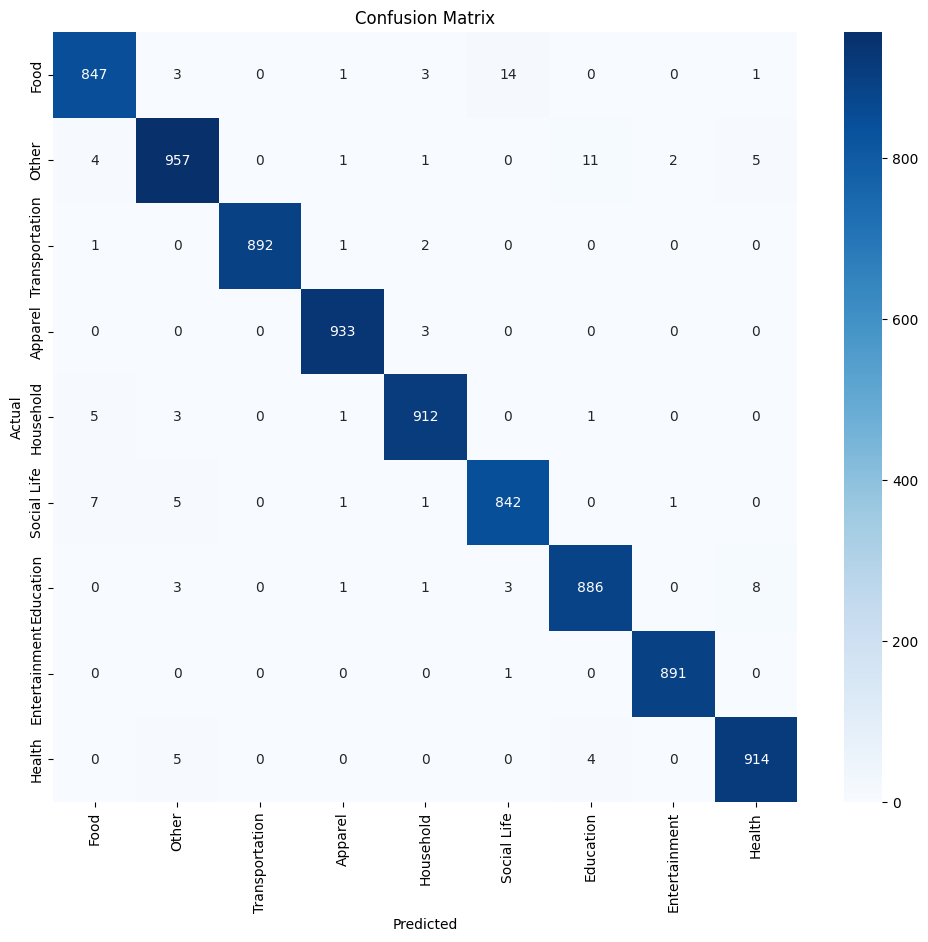

In [28]:
# Plotting confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[id_to_category[idx] for idx in range(len(category_to_id))], yticklabels=[id_to_category[idx] for idx in range(len(category_to_id))])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

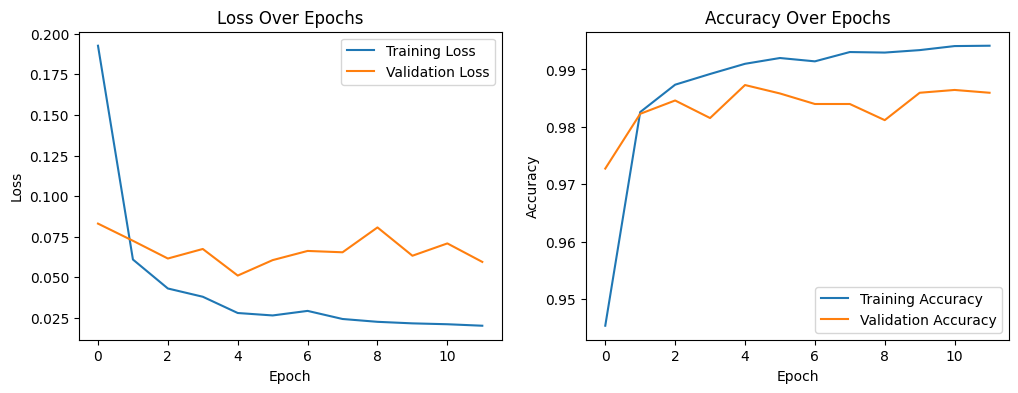

In [29]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
# Save the model and tokenizer
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [31]:
# Prediction function
def predict(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='tf')
    outputs = model(encodings)
    logits = outputs.logits
    predictions = tf.argmax(logits, axis=-1)
    return [id_to_category[pred.numpy()] for pred in predictions]

In [32]:
# Example usage of prediction
new_texts = ["Dinner at a restaurant", "Monthly salary", "Car", "HighSchool", "McDonalds"]
predictions = predict(new_texts)
print(predictions)

['Food', 'Other', 'Transportation', 'Food', 'Food']
